In [20]:
# Script to extract the data over country-shapes

In [ ]:
import pandas as pd
import geopandas as gpd
# Operations on geometries
import shapely
import numpy as np
import math
import xarray as xr
import regionmask

In [21]:
# Path files (change the paths accordingly)
mypath = '/Users/noeliaotero/Documents/OCCR/data'
sh_file = '/ref-nuts-2016-10m.shp/NUTS_RG_10M_2016_4326_LEVL_0.shp'
t2m = '/Users/noeliaotero/Documents/OCCR/data/data_CAS_ML/Daymean_era5_T2M_EU_19790101-20210905.nc'

In [22]:
nuts = gpd.read_file(mypath+sh_file)

In [23]:
nuts.head()

,LEVL_CODE,NUTS_ID,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,0,AL,AL,SHQIPËRIA,SHQIPËRIA,0,0,0,AL,"POLYGON ((19.82698 42.46950, 19.83939 42.46950..."
1,0,AT,AT,ÖSTERREICH,ÖSTERREICH,0,0,0,AT,"POLYGON ((15.54245 48.90770, 15.75363 48.85218..."
2,0,BE,BE,BELGIQUE-BELGIË,BELGIQUE-BELGIË,0,0,0,BE,"POLYGON ((5.10218 51.42900, 5.08780 51.38230, ..."
3,0,NL,NL,NEDERLAND,NEDERLAND,0,0,0,NL,"MULTIPOLYGON (((6.87491 53.40801, 6.91836 53.3..."
4,0,PL,PL,POLSKA,POLSKA,0,0,0,PL,"MULTIPOLYGON (((18.95003 54.35831, 19.35966 54..."


In [126]:
t2m_dat = xr.open_mfdataset(t2m, chunks = {'time': 10})
lons = t2m_dat.lon
lats = t2m_dat.lat


In [25]:
nn = len(nuts.NUTS_ID)

In [26]:
# Define the mask
nuts_mask_poly = regionmask.Regions(name = 'nuts_mask', numbers = list(range(0,nn)), names = list(nuts.NUTS_ID), abbrevs = list(nuts.NUTS_ID), outlines = list(nuts.geometry.values[i] for i in range(0,nn)))
print(nuts_mask_poly)

<regionmask.Regions>
Name:     nuts_mask

Regions:
 0 AL AL
 1 AT AT
 2 BE BE
 3 NL NL
 4 PL PL
.. .. ..
32 ME ME
33 MK MK
34 UK UK
35 MT MT
36 FR FR

[37 regions]


In [75]:
# Extract the ID for Switzerland
ID_CH = 11

In [76]:
# Important: pay attention to incresing (or decreasin order of latitude)
mask = nuts_mask_poly.mask(t2m_dat.isel(time = 0).sel(lat = slice(80,30), lon  = slice(-40, 40)), lat_name='lat', lon_name='lon')


<AxesSubplot:xlabel='lon', ylabel='lat'>

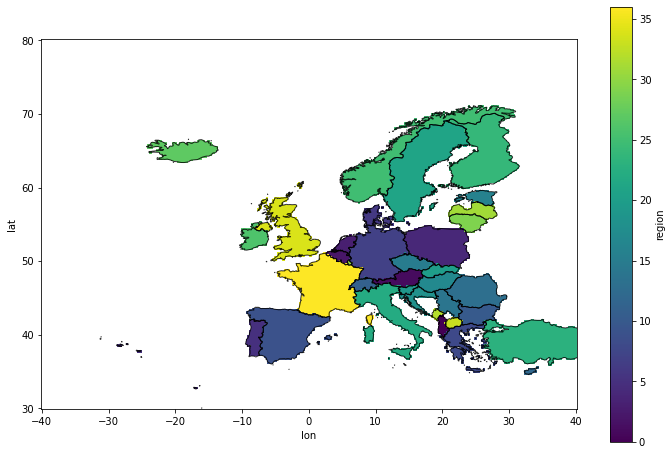

In [77]:
# Just to visualise
plt.figure(figsize=(12,8))
ax = plt.axes()
mask.plot(ax = ax)
nuts.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 1)

In [94]:
def extract_nuts_TS(nc, nuts_mask_poly, ID_country):
    # Important: pay attention to incresing (or decreasin order of latitude)
    mask = nuts_mask_poly.mask(nc.isel(time = 0).sel(lat = slice(80,30), lon  = slice(-40, 40)), lat_name='lat', lon_name='lon')
    lat = mask.lat.values
    lon = mask.lon.values
    var_country = list()
    meanvar_country = list()
    if ( ID_country == None ):
        for ID_REGION in range(0,37):
            print(ID_REGION)
            sel_mask = mask.where(mask == ID_REGION).values
            id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
            id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
            out_sel = nc.sel(lat = slice(id_lat[0], id_lat[-1]), lon = slice(id_lon[0], id_lon[-1])).compute().where(mask == ID_REGION)
            var_country.append(out_sel)
            # For doing country average
            x = out_sel.groupby('time').mean(...)
            meanvar_country.append(x)
    else:
        print(ID_country)        
        sel_mask = mask.where(mask == ID_country).values
        id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
        id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
        out_sel = nc.sel(lat = slice(id_lat[0], id_lat[-1]), lon = slice(id_lon[0], id_lon[-1])).compute().where(mask == ID_country)
        var_country.append(out_sel)
        # For doing country average
        x = out_sel.groupby('time').mean(...)
        meanvar_country.append(x)
        
    return(x)

In [99]:
t2m_CH = extract_nuts_TS(t2m_dat,nuts_mask_poly, ID_country = ID_CH)

11


In [122]:
def save_dataf(mdat, xvar, dout):
    df_ch = pd.DataFrame({'date':mdat['time'].values, xvar:mdat[xvar].values})
    # saving the dataframe 
    df_ch.to_csv(dir_out + 'df_'+ xvar + '_CH_1979-2021.csv', index = False, header=True)

    
    

In [123]:
dir_out = "/Users/noeliaotero/Documents/OCCR/data/data_CAS_ML/"

In [124]:
save_dataf(t2m_CH, 'T2MMEAN', dir_out)